# Main testing

In [1]:
import gym
import minihack
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from typing import Tuple, List
from utils import *
from algorithms import *
from logic import *

## Creazione dell environment

In [2]:
env = gym.make("MiniHack-River-Narrow-v0", observation_keys=("chars", "pixel"))
state = env.reset()
env.render()


You are lucky!  Full moon tonight.                                              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                          ........        ..}                                   
                          ........      ....}                                   
                          ....... .   ......}                                   
                          ......`.` ......                                      
                          .

In [3]:
state['chars'].shape, state['pixel'].shape

((21, 79), (336, 1264, 3))

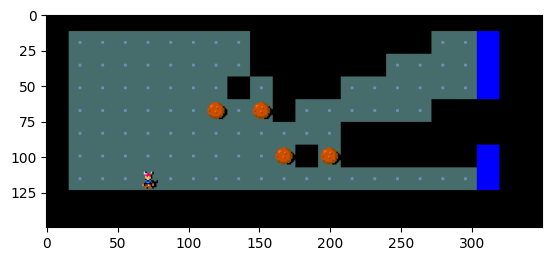

In [4]:
plt.imshow(state['pixel'][100:250, 400:750]) #Immagine ristretta con range [y][x]

In [5]:
game_map = state['chars']
game = state['pixel']

## Finding coordinates
Searching for the coordinates of the player, all the boulders and river

In [6]:
start = get_player_location(game_map)
boulders = get_boulder_locations(game_map)
print("Agent position:", start)


Agent position: (13, 29)


Coordinates of each block present in the map

In [7]:
print("Boulders positions: ", boulders)

Boulders positions:  [(10, 32), (10, 34), (12, 35), (12, 37)]


Calcolo la distanza del player dal blocco più vicino

In [8]:
target_block_position, distance = get_min_distance_point_to_points(start[0],start[1],boulders)
print("Target position:", target_block_position, "Distance:", distance)

Target position: 10 Distance: 32


### Finding river positions

In [9]:
river_positions = get_river_locations(game_map)

In [10]:
#Lista con le posizioni del fiume
river_positions

[(7, 44), (8, 44), (9, 44), (12, 44), (13, 44)]

In [11]:
k = get_min_distance_point_to_points(boulders[0][0],boulders[0][1], river_positions)

In [12]:
print(k)

(7, 44)


### Getting the coordinates of the best boulder to push

In [13]:
coordinates_min_boulder = get_best_global_distance(start, boulders, river_positions)
print("Coordinates of the best boulder to push: ",coordinates_min_boulder)

[(10, 32, 47), (10, 34, 49), (12, 35, 50), (12, 37, 52)]
Coordinates of the best boulder to push:  (10, 32)


## Complete path player - boulder - river

1) A star calculates the path from the player to the optimal boulder to push
2) A star calculates the path from the boulder reached to the nearest river position

## Path player to boulder

In [14]:
path_player_boulder = a_star(game,game_map, start, coordinates_min_boulder, get_optimal_distance_point_to_point)
print("Complete path to reach the target: ",path_player_boulder)

Target found!
Complete path to reach the target:  [(13, 29), (12, 30), (11, 31)]


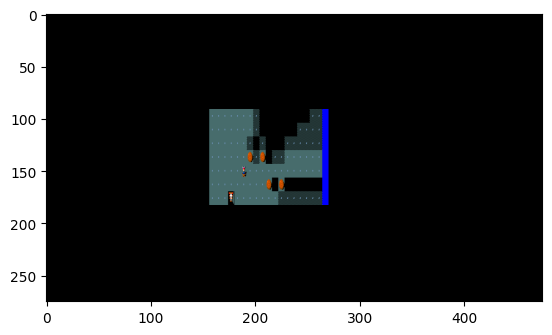

In [15]:
actions, names = actions_from_path(start, path_player_boulder[1:]) #Remove first action because it is the start position
import time

player_pos = plot_animated_sequence(env,game, game_map,actions)


Printing the actions that the player did to reach the target

In [16]:
names

['NE', 'NE']

## Path boulder to river

Calculating the coordinates of the shortest distance river position in which the boulder reached has to be dropped

In [17]:
final_position = get_min_distance_point_to_points(coordinates_min_boulder[0],coordinates_min_boulder[1], river_positions)


In [18]:
print("Boulders coordinates:",coordinates_min_boulder[0],coordinates_min_boulder[1],"River position: ", final_position)

path_boulder_river = a_star(game,game_map, coordinates_min_boulder, final_position, get_optimal_distance_point_to_point)
print("Complete path to reach the target: ",path_boulder_river)

Boulders coordinates: 10 32 River position:  (7, 44)
Target found!
Complete path to reach the target:  [(10, 32), (10, 33), (10, 34), (11, 35), (11, 36), (11, 37), (11, 38), (11, 39), (11, 40), (10, 41), (9, 42), (8, 43)]


In [19]:
get_min_distance_point_to_points(boulders[0][0],boulders[0][1], river_positions)

(7, 44)

In [20]:
push_boulder_path(path_boulder_river)

[(10, 31), (10, 32), (10, 32), (10, 33), (9, 33), (10, 34), (11, 34), (11, 35), (11, 35), (11, 36), (11, 36), (11, 37), (11, 37), (11, 38), (11, 38), (11, 39), (12, 39), (11, 40), (11, 40), (10, 41), (10, 41), (9, 42)]
['E', 'S', 'E', 'N', 'SE', 'S', 'E', 'S', 'E', 'S', 'E', 'S', 'E', 'S', 'E', 'S', 'NE', 'S', 'NE', 'S', 'NE']


([1, 2, 1, 0, 5, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 4, 2, 4, 2, 4],
 [(10, 31),
  (10, 32),
  (10, 32),
  (10, 33),
  (9, 33),
  (10, 34),
  (11, 34),
  (11, 35),
  (11, 35),
  (11, 36),
  (11, 36),
  (11, 37),
  (11, 37),
  (11, 38),
  (11, 38),
  (11, 39),
  (12, 39),
  (11, 40),
  (11, 40),
  (10, 41),
  (10, 41),
  (9, 42)])

In [21]:
actions, names = actions_from_path(start, names) #Remove first action because it is the start position

player_pos = plot_animated_sequence(env,game, game_map,actions)

UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None